# 6.1 - Credit risk scoring project

This week we will be creating a model that detects risk of default on a credit report.  
This is a binary classification problem where 0 is okay and 1 is default.  
g(xi) -> probability of default  
y -> target variable  
x -> features (information of users ie income)  

In [35]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 6.2 - Data cleaning and preparation
- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

## load data

In [36]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [37]:
!wget $data

--2023-10-23 07:14:10--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.04s   

2023-10-23 07:14:11 (3.98 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [38]:
!head CreditScoring.csv #linux tool that looks at first 10 rows of a text file

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [39]:
df = pd.read_csv(data)
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## clean data

In [40]:
#lowercase column names
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


There is documentation on mapping the categoricals

In [41]:
#map status
status_values = {
    1: 'ok',
    2: 'default',
    3: 'unknown'
}
df.status = df.status.map(status_values)

In [42]:
#map the rest of the variables to their respective strings from the documentation
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Now we want to handle missing values which are labeled as 99999999 according to the documentation

In [43]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


notice income, assets, and debt max values are all equal to the missing value label

In [44]:
#replace the missing value label to 'not a number'
df.income.replace(to_replace=99999999, value=np.nan).max()

959.0

In [45]:
#do this for all 3 columns
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan).max()

In [46]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,959.0,300000.0,30000.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,0.0,0.0,0.0,475.0,628.0
min,0.0,6.0,18.0,35.0,959.0,300000.0,30000.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,959.0,300000.0,30000.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,959.0,300000.0,30000.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,959.0,300000.0,30000.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [47]:
#drop unknown status
df = df[df.status != 'unknown'].reset_index(drop=True)

In [48]:
#split dataframes
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 11)

In [49]:
#reset indexes
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [51]:
#set target to 1 for default otherwise 0
y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values

In [53]:
#remove target variable from dataframes
del df_train['status']
del df_test['status']
del df_val['status']

# 6.3 - Decision trees
- What a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

basic example of a manually coded decision tree

In [55]:
#example of hardcoded decision tree
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [56]:
xi = df_train.iloc[0].to_dict()

In [57]:
assess_risk(xi)

'ok'

the decision tree classifier algorithm can determine the tree algorithmically

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer #for categorical variables
from sklearn.metrics import roc_auc_score

In [63]:
#convert variables to dicts
train_dicts = df_train.fillna(0).to_dict(orient='records') #adding fillna to avoid downstream error temporarily

In [64]:
#train dictionary vectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [65]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [66]:
#now do the same for validation and prediction
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [67]:
y_pred = dt.predict_proba(X_val)

In [68]:
#convert form 2d array to 1d to use roc auc
y_pred = dt.predict_proba(X_val)[:, 1]

In [71]:
roc_auc_score(y_val, y_pred)

0.6471989765015635

In [72]:
#now lets check the score for training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

The above example is overfitting

The default is a tree of infinite depth but you can actually set the depth manually and it will detect which decisions are best in this case

In [82]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [83]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7017132266649385
val: 0.6876073869887143


In this case performance is even better than the tree with infinite depth

You can also limit to a single decision which is called a "decision stump"

You can also visualize the tree

In [84]:
from sklearn.tree import export_text

In [85]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



# 6.4 - Decision tree learning algorithm
- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [87]:
#creating example data
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


We weant to train the decision tree algorithm where assets > t split where false creates df_left and true creates df_right

In [88]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [89]:
#let us create test threshold limits
Ts = [2000, 3000, 4000, 5000, 8000]

In [91]:
from IPython.display import display #adding display so we can print from inside the loop

#now let us evaluate which of these is the best
for t in Ts:
    df_left = df_example[df_example.assets <= t]
    df_right = df_example[df_example.assets > t]

    display(df_left)
    display(df_right)
    print()

,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


The algorithm takes the weighted average of the misclassification rate which is called 'impurity' and assesses the best decisions by this metric.

If you chart out each split the split at 3000 will have the lowest average impurity of 10%

But what if there are more than 1 features?

In [94]:
#creating example data
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [95]:

df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [96]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [97]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


Summarized model:  

For f in features:  
- Find all thresholds for f  
- For t in thresholds:  
  - Split dataset using "f>t" condition  
  - Compute the impurity of this split

Then the algorithm selects the condition with the lowest impurity

Stopping criteria:  
- Group already pure
- Tree reached depth limit
- Group too small to split

# 6.5 - Decision trees parameter tuning
- selecting max_depth
- selecting min_samples_leaf

In [101]:
#first we will look at max_depth
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]: #none means as many layers as possible
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%s -> %.3f' % (d, auc))

1 -> 0.613
2 -> 0.688
3 -> 0.737
4 -> 0.758
5 -> 0.763
6 -> 0.746
10 -> 0.679
15 -> 0.658
20 -> 0.635
None -> 0.642


Best value is 5 with 4 and 6 being close so we should have a depth of 4 or 5 layers. Less layers is easier to understand.

Now for each of the depths 4-6 lets take a look at `min_samples_leaf` which is the minimum # of samples needed at the leaf (2 leafs per stump)

In [104]:
scores = []

#next we will look at min_samples_leaf
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]: 
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))
        print('(%4s, %3d) -> %.3f' % (d, s, auc))

(   4,   1) -> 0.758
(   4,   2) -> 0.758
(   4,   5) -> 0.758
(   4,  10) -> 0.757
(   4,  15) -> 0.756
(   4,  20) -> 0.757
(   4, 100) -> 0.751
(   4, 200) -> 0.750
(   4, 500) -> 0.649
(   5,   1) -> 0.761
(   5,   2) -> 0.764
(   5,   5) -> 0.767
(   5,  10) -> 0.765
(   5,  15) -> 0.762
(   5,  20) -> 0.762
(   5, 100) -> 0.761
(   5, 200) -> 0.756
(   5, 500) -> 0.649
(   6,   1) -> 0.746
(   6,   2) -> 0.746
(   6,   5) -> 0.757
(   6,  10) -> 0.767
(   6,  15) -> 0.767
(   6,  20) -> 0.764
(   6, 100) -> 0.763
(   6, 200) -> 0.757
(   6, 500) -> 0.649


In [107]:
#using a dataframe to more easily see the best auc score
columns=['max_depth','min_samples_leaf','auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
21,6,10,0.767296
22,6,15,0.767030
11,5,5,0.766552
12,5,10,0.765170
23,6,20,0.763928
10,5,2,0.763863
24,6,100,0.763421
14,5,20,0.762077
13,5,15,0.761993
15,5,100,0.761202


In [110]:
#can pivot to visualize easier
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.757791  0.760726  0.746051
2                 0.757791  0.763863  0.746350
5                 0.757791  0.766552  0.757021
10                0.756709  0.765170  0.767296
15                0.756153  0.761993  0.767030
20                0.756873  0.762077  0.763928
100               0.751431  0.761202  0.763421
200               0.750368  0.755850  0.756833
500               0.648667  0.648667  0.648667

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

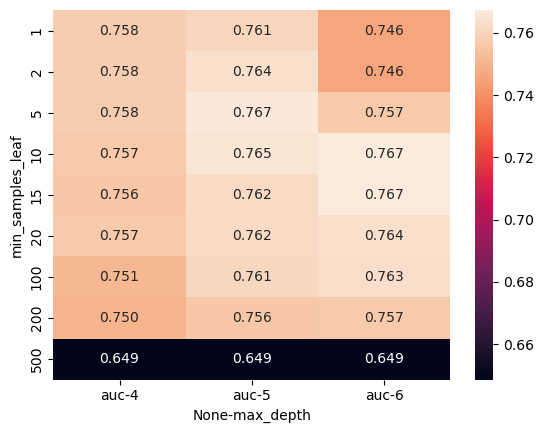

In [113]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [114]:
#now lets use these parameters to fit our model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# 6.6 - Ensembles and random forest
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

A random forest is like a board of directors. Each director is a decision tree whose features were randomized. By getting a consensus from n board of directors theoretically this will lead to a better decision than a single.

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
#let us test changing the number of estimators
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [123]:
df_scores = pd.DataFrame(scores, columns=['n_estimators','auc'])
df_scores

,n_estimators,auc
0,10,0.757676
1,20,0.770541
2,30,0.770804
3,40,0.769191
4,50,0.773647
5,60,0.776298
6,70,0.778276
7,80,0.780282
8,90,0.779855
9,100,0.780927


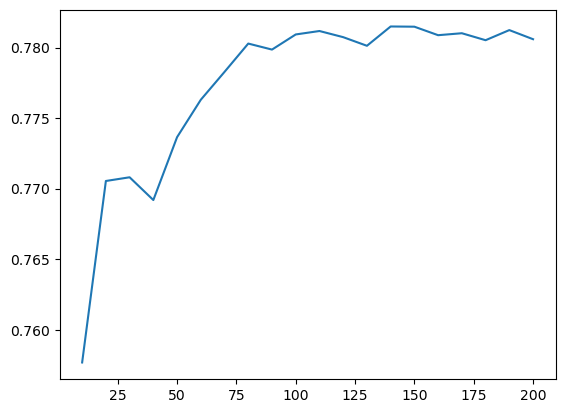

In [124]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [125]:
#now for each score we will test different depths
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [126]:
columns = ['max_depth','n_estimators','auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,auc
0,5,10,0.784287
1,5,20,0.781122
2,5,30,0.782278
3,5,40,0.786750
4,5,50,0.791573
5,5,60,0.792881
6,5,70,0.791950
7,5,80,0.792652
8,5,90,0.792436
9,5,100,0.792636


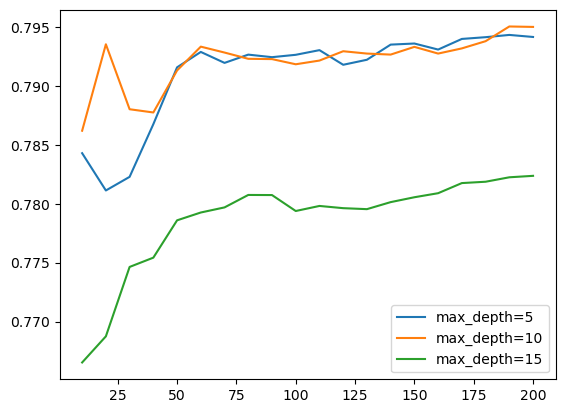

In [128]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [134]:
#deciding on max depth of 10
max_depth = 5

In [135]:
#now we will test the min_samples_leaf
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [136]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

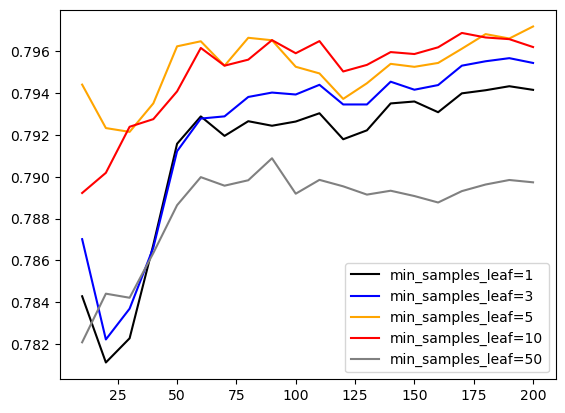

In [137]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [140]:
#deciding on mins_samples_leaf of 10
min_samples_leaf = 10

In [141]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=200,
                       random_state=1)

# 6.7 - Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

# 6.8 - XGBoost parameter tuning
- `eta`
- `max_depth`
- `min_child_weight`

# 6.9 - Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model